## Creating a Function while also computing the daily Climatology and Anomalies of the 2 meter Surface Temperature
## Based List of Cold Air Outbreaks

In [70]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import time
import warnings

import scipy.stats

warnings.simplefilter(action='ignore', category=FutureWarning)

In [71]:
#Creating a couple of funtions to create the monthly climatology and to create the anomalies

def create_climo(dataset, time='time', value ='t2m'):
    climatology = dataset.groupby(f'{time}.month').mean(dim=time)
    return climatology

def create_anom(dataset, time='time', value = 't2m'):
    anomaly= dataset.groupby(f'{time}.dayofyear')- dataset.groupby(f'{time}.dayofyear').mean(dim=time)
    return anomaly

In [72]:
#opening t2m era interim dataset

file = "/scratch/kbarrag/clim680_dataset/mean/t2m/erai.T2m.day.mean.1979-2019.nc"
ds1 = xr.open_dataset(file)
ds1

<xarray.Dataset>
Dimensions:  (lon: 480, lat: 200, time: 14853)
Coordinates:
  * lon      (lon) float64 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
  * lat      (lat) float64 -59.25 -58.5 -57.75 -57.0 ... 87.75 88.5 89.25 90.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    t2m      (time, lat, lon) float32 ...

In [73]:
#Selecting the location on the map that we are interested in: North America
#This dataset is a bit courser than 500hPa 

ds_t2m = ds1.sel(lon =slice(360-180,360-0),lat= slice(0,90))
ds_t2m

<xarray.Dataset>
Dimensions:  (lon: 240, lat: 121, time: 14853)
Coordinates:
  * lon      (lon) float64 180.0 180.8 181.5 182.2 ... 357.0 357.8 358.5 359.2
  * lat      (lat) float64 0.0 0.75 1.5 2.25 3.0 ... 87.0 87.75 88.5 89.25 90.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    t2m      (time, lat, lon) float32 ...

In [74]:
#Using the function to create a climotology and subtracting 272 to go to Celsius since out data is in K originally

ds_t2m_climo = create_climo(ds_t2m)-272
ds_t2m_climo

<xarray.Dataset>
Dimensions:  (lon: 240, lat: 121, month: 12)
Coordinates:
  * lon      (lon) float64 180.0 180.8 181.5 182.2 ... 357.0 357.8 358.5 359.2
  * lat      (lat) float64 0.0 0.75 1.5 2.25 3.0 ... 87.0 87.75 88.5 89.25 90.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m      (month, lat, lon) float32 28.6 28.55 28.5 ... -24.11 -24.11 -24.11

Text(0.5, 0.98, 'Monthly Climatology for Surface Temperature from Jan 1979 - Aug 2019')

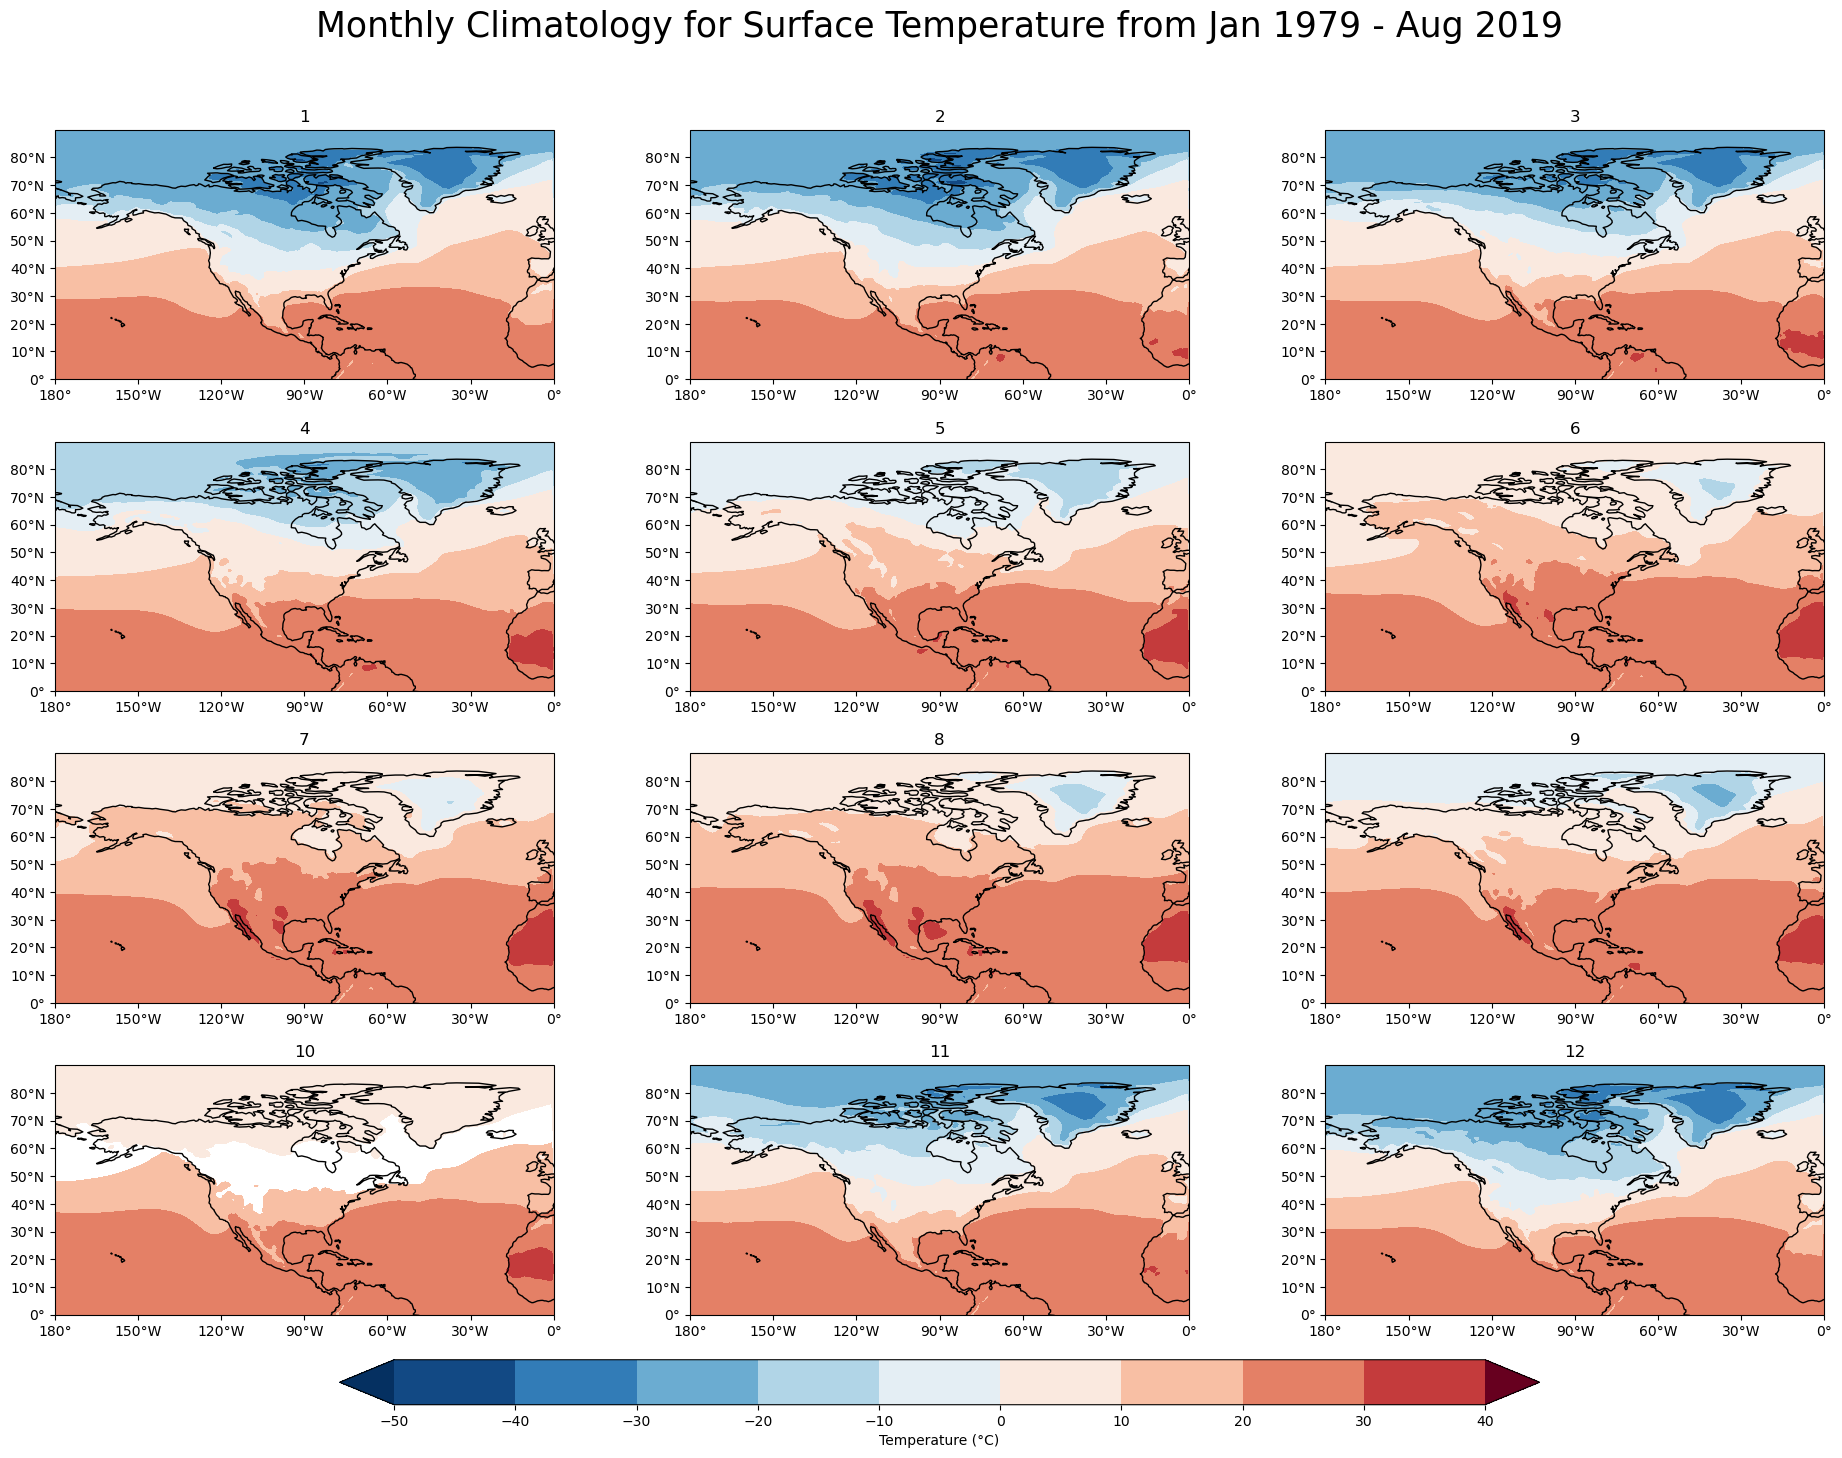

In [75]:
#Here we are plotting the monthly climatology


#Now to combine with a 'for' loop to create the plot                
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

 
# We will flatten it into a 1-D array
axs=axs.flatten()

min_z500= ds_t2m_climo['t2m'].min()
max_z500= ds_t2m_climo['t2m'].max()


clevs = np.arange(-50,50,10)

divnorm = colors.CenteredNorm(vcenter=0)

axs=axs.flatten()

#Loop over all of the day and plot
for i, time in enumerate(ds_t2m_climo['month']):

    # Select the day
    data=ds_t2m_climo['t2m'].sel(month=time)

    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=ds_t2m_climo['lon'])

    cs1=axs[i].contourf(lons, 
                ds_t2m_climo['lat'],data,
                clevs,
                norm=divnorm,
                cmap= "RdBu_r",
                transform = ccrs.PlateCarree(),
                extend='both')

    # Title each subplot with the name of the model
    axs[i].set_title(time.values, fontsize=12)
    
    
    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    axs[i].set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(0,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter) 

    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())
    
    fig.subplots_adjust( top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25)

#Colorbar(location, how far to bottom, how long,how tall
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal',label='Temperature (°C)')



plt.suptitle('Monthly Climatology for Surface Temperature from Jan 1979 - Aug 2019', fontsize=25 )

In [76]:
#Now creating the anomalies with the surface temperature

ds_t2m_anomaly= create_anom(ds_t2m)
ds_t2m_anomaly

<xarray.Dataset>
Dimensions:    (lon: 240, lat: 121, time: 14853)
Coordinates:
  * lon        (lon) float64 180.0 180.8 181.5 182.2 ... 357.0 357.8 358.5 359.2
  * lat        (lat) float64 0.0 0.75 1.5 2.25 3.0 ... 87.75 88.5 89.25 90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 236 237 238 239 240 241 242 243
Data variables:
    t2m        (time, lat, lon) float32 -0.626 -0.5733 -0.6013 ... 2.37 2.37

In [77]:
#These are the specific dates from Smith 2015 that are relevant to the time period in dataset
#Turning them into datetime format and sorting them by date :D

specific_dates = ['1981-01-07','1982-01-06','1984-01-13','1985-01-29','1988-01-04','1989-01-31','1994-01-12','1996-01-25','2010-01-02', 
                  '1979-02-05','1980-02-26','2007-02-01','2015-02-12',
                 '1983-12-14','1985-12-13','1989-12-11', '1995-12-07', '2000-12-17','2000-12-29','2005-12-01']
cao_dates = pd.to_datetime(specific_dates)
cao_dates_sorted = cao_dates.sort_values()
cao_dates_sorted

DatetimeIndex(['1979-02-05', '1980-02-26', '1981-01-07', '1982-01-06',
               '1983-12-14', '1984-01-13', '1985-01-29', '1985-12-13',
               '1988-01-04', '1989-01-31', '1989-12-11', '1994-01-12',
               '1995-12-07', '1996-01-25', '2000-12-17', '2000-12-29',
               '2005-12-01', '2007-02-01', '2010-01-02', '2015-02-12'],
              dtype='datetime64[ns]', freq=None)

In [78]:
#using the specific cao dates and selecting them from the anomaly dataset

cao_dates= ds_t2m_anomaly.sel(time=cao_dates_sorted)
cao_dates

<xarray.Dataset>
Dimensions:    (lon: 240, lat: 121, time: 20)
Coordinates:
  * lon        (lon) float64 180.0 180.8 181.5 182.2 ... 357.0 357.8 358.5 359.2
  * lat        (lat) float64 0.0 0.75 1.5 2.25 3.0 ... 87.75 88.5 89.25 90.0
  * time       (time) datetime64[ns] 1979-02-05 1980-02-26 ... 2015-02-12
    dayofyear  (time) int64 36 57 7 6 348 13 29 347 ... 25 352 364 335 32 2 43
Data variables:
    t2m        (time, lat, lon) float32 -0.8476 -0.5318 -0.2809 ... 5.893 5.893

Text(0.5, 0.98, '2 meter Surface Temperature Anomalies for Selected Cold Air Outbreaks from 1979-2019')

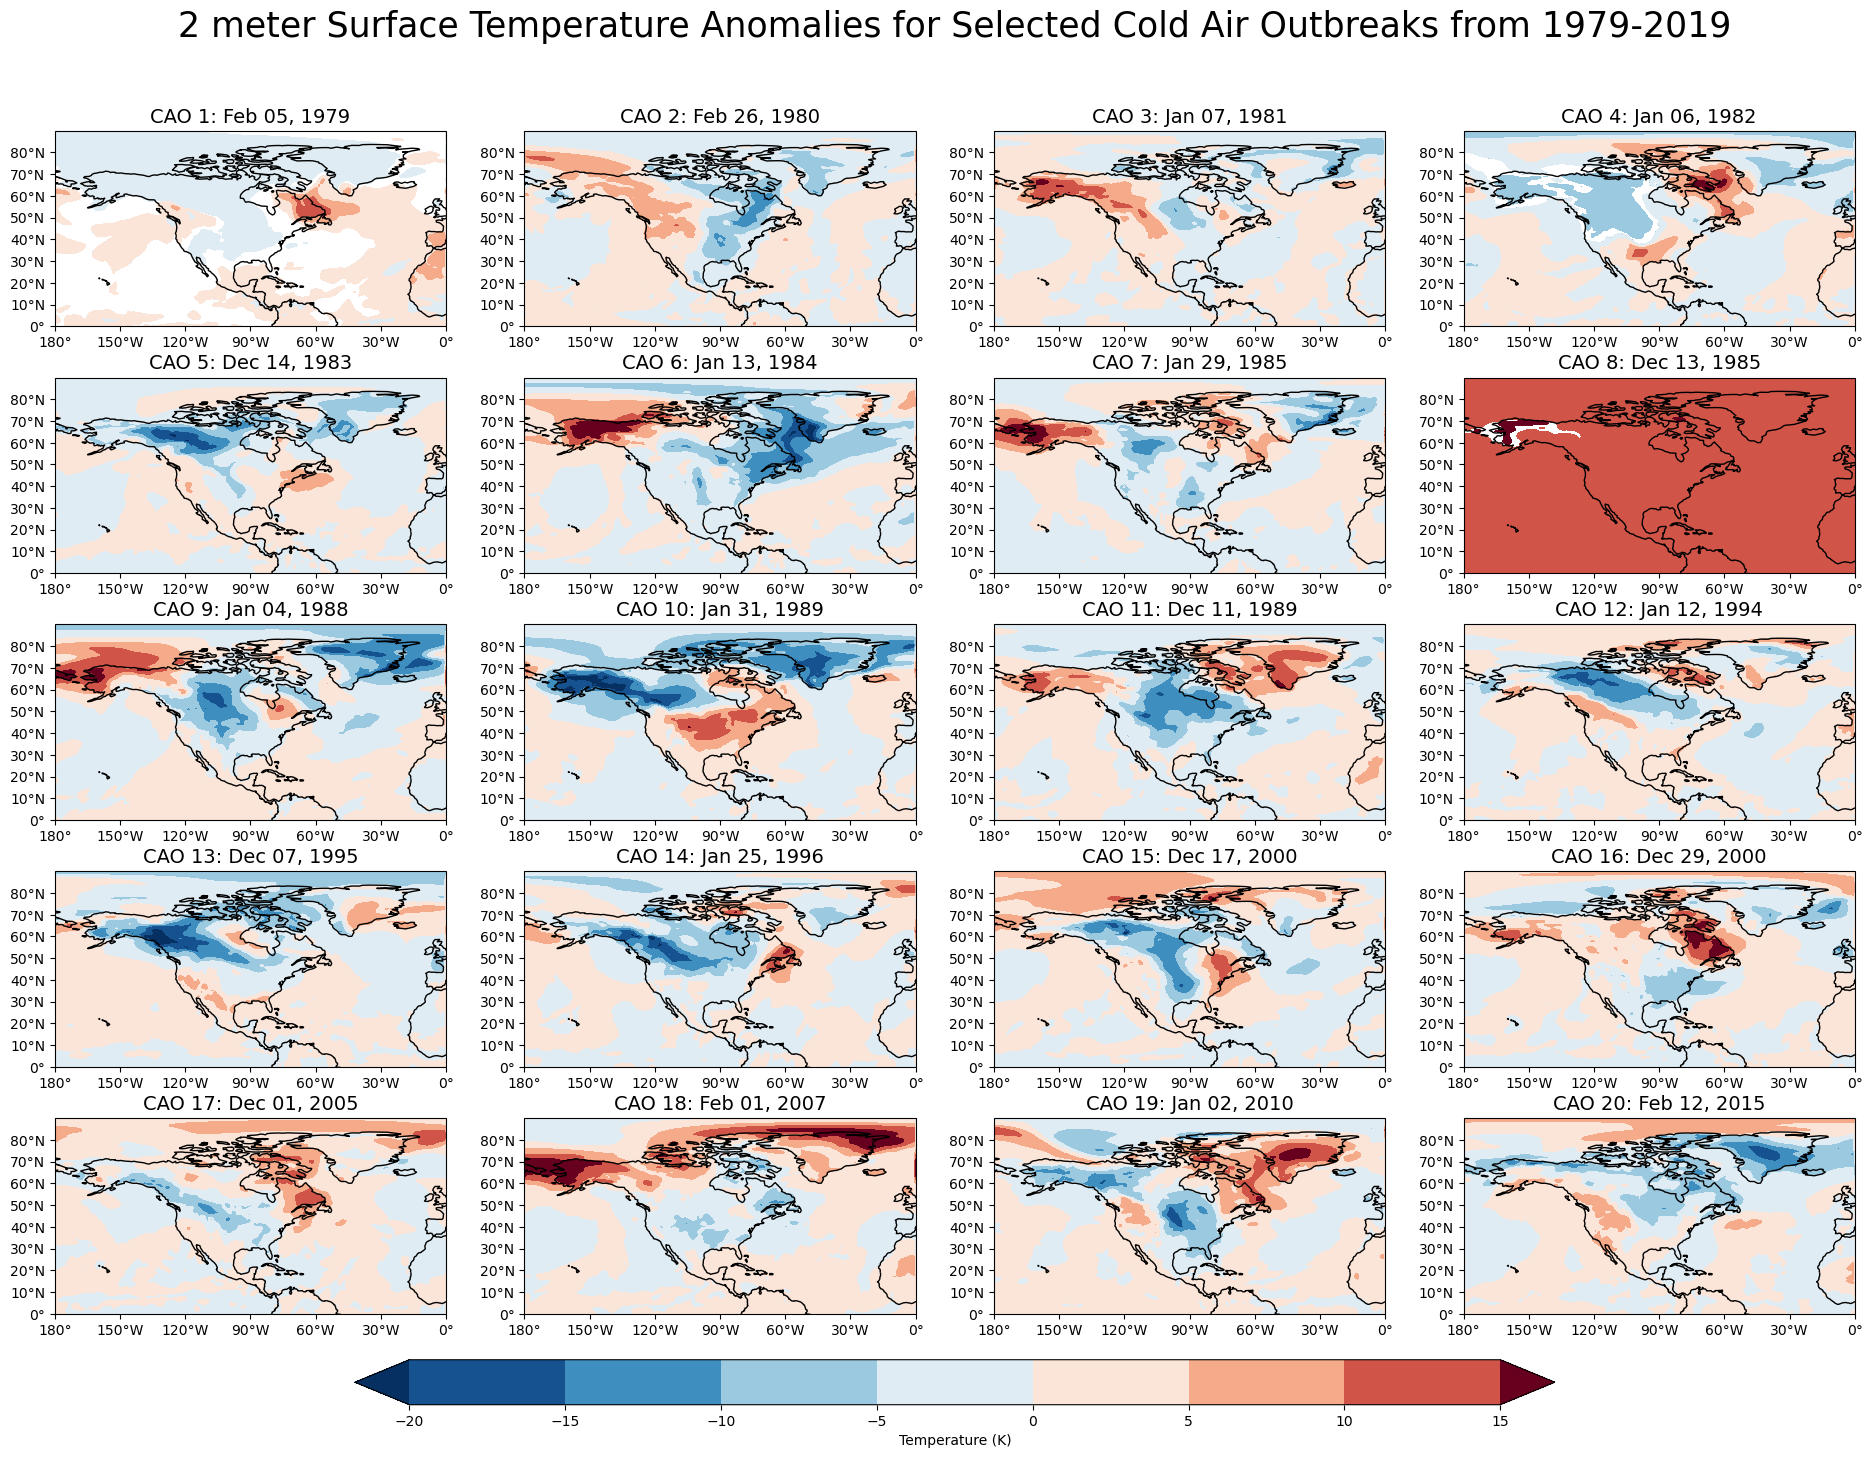

In [79]:
#Now we are plotting the CAO anomalies with 2 meter temperature 
#Since they are a difference the units can be K or C since it was originally in K we left in K 

#Now to combine with a 'for' loop to create the plot               
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=5,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

 
# We will flatten it into a 1-D array
axs=axs.flatten()

min_z500= cao_dates['t2m'].min()
max_z500= cao_dates['t2m'].max()


clevs = np.arange(-20,20,5)

divnorm = colors.CenteredNorm(vcenter=0)

axs=axs.flatten()

#Loop over all of the day and plot
for i, time in enumerate(cao_dates['time']):

    # Select the day
    data=cao_dates['t2m'].sel(time=time)

    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=cao_dates['lon'])

    cs1=axs[i].contourf(lons, 
                cao_dates['lat'],data,
                clevs,
                norm=divnorm,
                cmap= "RdBu_r",
                transform = ccrs.PlateCarree(),
                extend='both')
    
    # Title each subplot with the date of the CAO 
    formatted_date = time.dt.strftime('%b %d, %Y').values
    axs[i].set_title(f'CAO {i+1}: {formatted_date}', fontsize=14)
    
    #axs[i].set_title(time.values)
    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    axs[i].set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(0,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter) 

    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())
    
    fig.subplots_adjust( top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25)

#Colorbar(location, how far to bottom, how long,how tall
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal',label='Temperature (K)')



plt.suptitle('2 meter Surface Temperature Anomalies for Selected Cold Air Outbreaks from 1979-2019', fontsize=25 )

In [80]:
#Now sure what happened with Dec 13, 1985. Will see if there is a difference when compared with ERA 5 dataset
